In [241]:
import pandas as pd
import numpy as np

import geopandas as gpd
import matplotlib.pyplot as plt

from typing import Dict
import seaborn as sns


In [242]:
df=  pd.read_csv("final_aadhar_data_cleaned.csv")

In [243]:
# Parse date
df["date"] = pd.to_datetime(df["date"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004432 entries, 0 to 1004431
Data columns (total 11 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   date                    1004432 non-null  datetime64[ns]
 1   state                   1004432 non-null  object        
 2   pincode                 1004432 non-null  int64         
 3   district                1004432 non-null  object        
 4   age_0_5                 1004432 non-null  int64         
 5   age_5_17                1004432 non-null  int64         
 6   age_18_greater          1004432 non-null  int64         
 7   total_daily_enrolement  1004432 non-null  int64         
 8   day                     1004432 non-null  int64         
 9   day_name                1004432 non-null  object        
 10  month_name              1004432 non-null  object        
dtypes: datetime64[ns](1), int64(6), object(4)
memory usage: 84.3+ MB


### National Analysis 

In [244]:
observed_reporting_days = df['date'].nunique()
states_reporting = df['state'].nunique()
districts_standardized = df['district'].nunique()

print(f"Observed reporting days: {observed_reporting_days}")
print(f"States and UTs reported: {states_reporting}")
print(f"Districts standardized(Cleaned): {districts_standardized}")

Observed reporting days: 92
States and UTs reported: 36
Districts standardized(Cleaned): 801


In [245]:
# Total enrolments (reported days only)
total_enrolments = df['total_daily_enrolement'].sum()

# Number of national reporting days
national_reporting_days = df['date'].nunique()

# Average enrolments per reported day (India)
avg_enrolments_per_reported_day = total_enrolments / national_reporting_days



national_metrics_df = pd.DataFrame({
    "Metric": [
        "Total enrolments (reported days only)",
        "Average enrolments per reported day (India)"
    ],
    "Value": [
        int(total_enrolments),
        round(avg_enrolments_per_reported_day, 2)
    ]
})

national_metrics_df

,Metric,Value
0,Total enrolments (reported days only),5429665.0
1,Average enrolments per reported day (India),59018.1


In [246]:
import plotly.express as px
# Age-group totals
age_data = pd.DataFrame({
    "Age Group": ["0–5 years", "5–17 years", "18+ years"],
    "Enrolments": [
        df['age_0_5'].sum(),
        df['age_5_17'].sum(),
        df['age_18_greater'].sum()
    ]
})
# Percentage share
age_data["Share (%)"] = (age_data["Enrolments"] / total_enrolments) * 100
age_data["Share (%)"] = age_data["Share (%)"].round(2)
fig = px.pie(
    age_data,
    values="Share (%)",
    names="Age Group",
    title="National Aadhaar Enrolment Composition by Age Group<br><sup>(Reported Days Only)</sup>",
    hole=0.4  # donut-style, acceptable in policy dashboards
)

fig.update_traces(
    textposition="inside",
    textinfo="percent+label",
    pull=[0.03, 0.03, 0.03],  # subtle emphasis, not misleading
)

fig.update_layout(
    legend_title="Age Group",
    transition_duration=600  # smooth animation
)

fig.show()



In [247]:

age_data

,Age Group,Enrolments,Share (%)
0,0–5 years,3542135,65.24
1,5–17 years,1719435,31.67
2,18+ years,168095,3.10


In [248]:
# National daily enrolments
national_daily_enrolment = (
    df.groupby('date')['total_daily_enrolement']
      .sum()
      .reset_index(name='total_enrolments')
)

# Number of reporting districts per date
national_daily_districts = (
    df.groupby('date')['district']
      .nunique()
      .reset_index(name='reporting_districts')
)

# Merge
national_daily = pd.merge(
    national_daily_enrolment,
    national_daily_districts,
    on='date',
    how='inner'
)

national_daily.head()

,date,total_enrolments,reporting_districts
0,2025-03-02,109,1
1,2025-03-09,3404,24
2,2025-03-15,3102,18
3,2025-03-20,6218,38
4,2025-03-23,576,6


In [249]:
import plotly.graph_objects as go

fig = go.Figure()

# Line 1: Total enrolments
fig.add_trace(
    go.Scatter(
        x=national_daily['date'],
        y=national_daily['total_enrolments'],
        mode='lines+markers',
        name='Total Enrolments (India)',
        yaxis='y1'
    )
)

# Line 2: Reporting districts
fig.add_trace(
    go.Scatter(
        x=national_daily['date'],
        y=national_daily['reporting_districts'],
        mode='lines+markers',
        name='Reporting Districts',
        yaxis='y2'
    )
)

fig.update_layout(
    title="National Aadhaar Enrolment and Reporting Coverage Over Time<br><sup>(Reported Days Only)</sup>",
    xaxis_title="Date",
    yaxis=dict(
        title="Total Enrolments",
        side="left"
    ),
    yaxis2=dict(
        title="Number of Reporting Districts",
        overlaying="y",
        side="right"
    ),
    legend=dict(x=0.01, y=0.99),
    transition_duration=600
)

fig.show()


In [250]:
print(
    "Interpretation Note:\n"
    "Daily variation reflects a combination of enrolment activity and reporting coverage.\n "
    "Higher enrolment totals often coincide with a greater number of reporting districts. \n"
    "This chart does not imply behavioural or policy-driven changes in demand."
)


Interpretation Note:
Daily variation reflects a combination of enrolment activity and reporting coverage.
 Higher enrolment totals often coincide with a greater number of reporting districts. 
This chart does not imply behavioural or policy-driven changes in demand.


In [251]:
# Ensure correct weekday order
weekday_order = [
    'Monday', 'Tuesday', 'Wednesday',
    'Thursday', 'Friday', 'Saturday', 'Sunday'
]

# Aggregate by day of week
daywise_enrolment = (
    df.groupby('day_name')['total_daily_enrolement']
      .sum()
      .reindex(weekday_order)
      .reset_index()
)

daywise_enrolment.columns = ['Day of Week', 'Total Enrolments']

# Plot
fig_week = px.histogram(
    daywise_enrolment,
    x='Day of Week',
    y='Total Enrolments',
    title='Total Aadhaar Enrolment by Day of Week<br><sup>(Reported Records Only)</sup>',
    text_auto=True
)

fig_week.update_layout(
    xaxis_title='Day of Week',
    yaxis_title='Total Enrolments',
    transition_duration=600
)

fig_week.show()

In [252]:
print(
    "Remark on Interpretation (Day of Week):\n"
    "The observed peak on Tuesday reflects the aggregation of enrolment records across \n"
    "uneven reporting dates rather than a consistent weekday effect. \n"
    "Notably, the highest single-day enrolment volume \n"
    "(616,868 enrolments) occurred on 1 July 2025, which fell on a Tuesday, \n"
    "and several other high-volume reporting dates also align with specific weekdays. \n"
    "As reporting is non-continuous and varies across months, aggregation by weekday \n"
    "can disproportionately amplify isolated reporting events. "
    "Therefore, higher totals for specific weekdays should not be interpreted as evidence \n"
    "of enrolment behaviour, operational preference, or demand cycles.\n"
)


Remark on Interpretation (Day of Week):
The observed peak on Tuesday reflects the aggregation of enrolment records across 
uneven reporting dates rather than a consistent weekday effect. 
Notably, the highest single-day enrolment volume 
(616,868 enrolments) occurred on 1 July 2025, which fell on a Tuesday, 
and several other high-volume reporting dates also align with specific weekdays. 
As reporting is non-continuous and varies across months, aggregation by weekday 
can disproportionately amplify isolated reporting events. Therefore, higher totals for specific weekdays should not be interpreted as evidence 
of enrolment behaviour, operational preference, or demand cycles.



In [253]:
day_of_month_enrolment = (
    df.groupby('day')['total_daily_enrolement']
      .sum()
      .reset_index()
      .sort_values('day')
)

fig_dom = px.bar(
    day_of_month_enrolment,
    x='day',
    y='total_daily_enrolement',
    title='Total Aadhaar Enrolment by Day of Month<br><sup>(Reported Records Only)</sup>',
    labels={
        'day': 'Day of Month',
        'total_daily_enrolement': 'Total Enrolments'
    }
)

fig_dom.update_layout(
    xaxis=dict(
        tickmode='linear',
        tick0=1,
        dtick=1
    ),
    transition_duration=600
)

fig_dom.show()


In [254]:
print(
    "Remark on Interpretation (Day of Month):\n"
    "The pronounced spike on the 1st day of the month is driven by concentrated reporting \n"
    "on a small number of specific dates rather than uniform daily activity. \n"
    "In particular, enrolment totals for April, May, and June are each based on a single \n"
    "reported date corresponding to the 1st of the month. \n"
    "Additionally, the highest single-day enrolment volume \n"
    "(616,868 enrolments) was reported on 1 July 2025. \n"
    "Given non-continuous and uneven reporting coverage across months, aggregation by \n"
    "calendar day amplifies these isolated reporting events. \n"
    "Accordingly, this pattern should not be interpreted as a systematic preference for \n"
    "enrolment on the 1st day of the month.\n"
)



Remark on Interpretation (Day of Month):
The pronounced spike on the 1st day of the month is driven by concentrated reporting 
on a small number of specific dates rather than uniform daily activity. 
In particular, enrolment totals for April, May, and June are each based on a single 
reported date corresponding to the 1st of the month. 
Additionally, the highest single-day enrolment volume 
(616,868 enrolments) was reported on 1 July 2025. 
Given non-continuous and uneven reporting coverage across months, aggregation by 
calendar day amplifies these isolated reporting events. 
Accordingly, this pattern should not be interpreted as a systematic preference for 
enrolment on the 1st day of the month.



In [255]:
# State-level aggregation
state_stats = (
    df.groupby('state')
      .agg(
          total_enrolments=('total_daily_enrolement', 'sum'),
          reporting_days=('date', 'nunique')
      )
      .reset_index()
)

# Coverage percentage
state_stats['coverage_pct'] = (
    state_stats['reporting_days'] / national_reporting_days * 100
)

# Average enrolments per reported day
state_stats['avg_enrolments_per_reported_day'] = (
    state_stats['total_enrolments'] / state_stats['reporting_days']
)

state_stats.head()

,state,total_enrolments,reporting_days,coverage_pct,avg_enrolments_per_reported_day
0,Andaman and Nicobar Islands,511,68,73.913043,7.514706
1,Andhra Pradesh,127686,82,89.130435,1557.146341
2,Arunachal Pradesh,4344,78,84.782609,55.692308
3,Assam,230197,85,92.391304,2708.200000
4,Bihar,609585,88,95.652174,6927.102273


In [256]:
coverage_threshold = 0.70 * national_reporting_days

state_filtered = state_stats[
    state_stats['reporting_days'] >= coverage_threshold
].copy()

len(state_filtered)


35

In [ ]:
top15_states = (
    state_filtered
    .sort_values('avg_enrolments_per_reported_day', ascending=False)
    .head(15)
)



In [258]:
import plotly.express as px

fig = px.bar(
    top15_states.sort_values('avg_enrolments_per_reported_day'),
    x='avg_enrolments_per_reported_day',
    y='state',
    orientation='h',
    title=(
        'Top 15 States by Average Aadhaar Enrolments per Reported Day<br>'
        '<sup>(States with ≥70% National Reporting Coverage)</sup>'
    ),
    labels={
        'avg_enrolments_per_reported_day': 'Avg Enrolments per Reported Day',
        'state': 'State'
    },
    hover_data={
        'reporting_days': True,
        'coverage_pct': ':.1f',
        'total_enrolments': True
    }
)

fig.update_layout(transition_duration=600)
fig.show()


In [259]:
validation_table = (
    top15_states[[
        'state',
        'reporting_days',
        'coverage_pct',
        'avg_enrolments_per_reported_day',
        'total_enrolments'
    ]]
    .sort_values('avg_enrolments_per_reported_day', ascending=False)
)

# Round for readability
validation_table['coverage_pct'] = validation_table['coverage_pct'].round(1)
validation_table['avg_enrolments_per_reported_day'] = (
    validation_table['avg_enrolments_per_reported_day'].round(0).astype(int)
)

validation_table


,state,reporting_days,coverage_pct,avg_enrolments_per_reported_day,total_enrolments
33,Uttar Pradesh,88,95.7,11575,1018629
4,Bihar,88,95.7,6927,609585
19,Madhya Pradesh,87,94.6,5678,493970
35,West Bengal,84,91.3,4468,375340
20,Maharashtra,87,94.6,4243,369139
28,Rajasthan,84,91.3,4148,348458
10,Gujarat,85,92.4,3301,280549
3,Assam,85,92.4,2708,230197
30,Tamil Nadu,84,91.3,2628,220789
15,Karnataka,85,92.4,2626,223235


In [260]:
print(
    "Interpretation Note:\n"
    "State-level averages are computed over dates on which at least one enrolment \n"
    "record is reported for the state. Coverage reflects temporal presence only and \n"
    "does not imply complete district-level reporting on each date. Comparisons are \n"
    "descriptive and do not indicate enrolment demand or administrative performance.\n"
)



Interpretation Note:
State-level averages are computed over dates on which at least one enrolment 
record is reported for the state. Coverage reflects temporal presence only and 
does not imply complete district-level reporting on each date. Comparisons are 
descriptive and do not indicate enrolment demand or administrative performance.



In [261]:
# National reporting window
national_reporting_days = df['date'].nunique()

# State-level stats
state_stats = (
    df.groupby('state')
    .agg(
        total_enrolments=('total_daily_enrolement', 'sum'),
        reporting_days=('date', 'nunique'),
        age_0_5=('age_0_5', 'sum'),
        age_5_17=('age_5_17', 'sum'),
        age_18_plus=('age_18_greater', 'sum')
    )
    .reset_index()
)

state_stats['avg_enrolments_per_reported_day'] = (
    state_stats['total_enrolments'] / state_stats['reporting_days']
)

# Coverage filter (same as before: ≥70%)
coverage_threshold = 0.70 * national_reporting_days

state_stats_filtered = state_stats[
    state_stats['reporting_days'] >= coverage_threshold
]

# Top 15 states
top15_states = (
    state_stats_filtered
    .sort_values('avg_enrolments_per_reported_day', ascending=False)
    .head(15)
)

top15_states[['state', 'avg_enrolments_per_reported_day']]
age_cols = ['age_0_5', 'age_5_17', 'age_18_plus']

top15_states['age_0_5_pct'] = (
    top15_states['age_0_5'] / top15_states['total_enrolments'] * 100
)
top15_states['age_5_17_pct'] = (
    top15_states['age_5_17'] / top15_states['total_enrolments'] * 100
)
top15_states['age_18_plus_pct'] = (
    top15_states['age_18_plus'] / top15_states['total_enrolments'] * 100
)
age_long = top15_states.melt(
    id_vars=['state'],
    value_vars=['age_0_5_pct', 'age_5_17_pct', 'age_18_plus_pct'],
    var_name='Age Group',
    value_name='Share (%)'
)

age_long['Age Group'] = age_long['Age Group'].replace({
    'age_0_5_pct': '0–5 years',
    'age_5_17_pct': '5–17 years',
    'age_18_plus_pct': '18+ years'
})


In [262]:
import plotly.express as px

fig_age_state = px.bar(
    age_long,
    x='state',
    y='Share (%)',
    color='Age Group',
    title=(
        "Age-Group Composition of Aadhaar Enrolment Activity<br>"
        "Top 15 States by Average Enrolments per Reported Day"
    ),
    labels={
        'state': 'State',
        'Share (%)': 'Share of Enrolment Transactions (%)'
    }
)

fig_age_state.update_layout(
    xaxis_tickangle=-45,
    yaxis=dict(range=[0, 100]),
    legend_title='Age Group',
    transition_duration=600
)

fig_age_state.show()


In [263]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt


In [264]:
# Load India state boundary GeoJSON (ADM1)
india_states_gdf = gpd.read_file("geoBoundaries-IND-ADM1.geojson")
india_states_gdf.head()


,shapeName,shapeISO,shapeID,shapeGroup,shapeType,geometry
0,Puducherry,IN-PY,1811400B81659894240990,IND,ADM1,"MULTIPOLYGON (((75.53056 11.70403, 75.53015 11..."
1,Mahārāshtra,IN-MH,1811400B15614733245507,IND,ADM1,"MULTIPOLYGON (((80.27289 18.72299, 80.27266 18..."
2,Nāgāland,IN-NL,1811400B74762431478096,IND,ADM1,"POLYGON ((95.23392 26.68246, 95.23339 26.68291..."
3,Lakshadweep,IN-LD,1811400B55669546485086,IND,ADM1,"MULTIPOLYGON (((73.01113 8.27759, 73.01103 8.2..."
4,Uttar Pradesh,IN-UP,1811400B11231190780494,IND,ADM1,"MULTIPOLYGON (((79.39526 25.03209, 79.39598 25..."


In [265]:
# National reporting window
national_reporting_days = df['date'].nunique()

# State-level metrics
state_stats = (
    df.groupby('state')
      .agg(
          total_enrolments=('total_daily_enrolement', 'sum'),
          reporting_days=('date', 'nunique')
      )
      .reset_index()
)

state_stats['avg_enrolments_per_reported_day'] = (
    state_stats['total_enrolments'] / state_stats['reporting_days']
)

state_stats['coverage_pct'] = (
    state_stats['reporting_days'] / national_reporting_days * 100
)

state_stats.head()



,state,total_enrolments,reporting_days,avg_enrolments_per_reported_day,coverage_pct
0,Andaman and Nicobar Islands,511,68,7.514706,73.913043
1,Andhra Pradesh,127686,82,1557.146341,89.130435
2,Arunachal Pradesh,4344,78,55.692308,84.782609
3,Assam,230197,85,2708.200000,92.391304
4,Bihar,609585,88,6927.102273,95.652174


In [266]:
import unicodedata

def normalize_name(name):
    if pd.isna(name):
        return name
    # Remove diacritics
    name = unicodedata.normalize('NFKD', name)
    name = ''.join([c for c in name if not unicodedata.combining(c)])
    # Lowercase and strip
    name = name.lower().strip()
    return name


In [267]:
# Aadhaar data
state_stats['state_norm'] = state_stats['state'].apply(normalize_name)

# GeoJSON data
india_states_gdf['state_norm'] = india_states_gdf['shapeName'].apply(normalize_name)


In [268]:
sorted(state_stats['state_norm'].unique())



['andaman and nicobar islands',
 'andhra pradesh',
 'arunachal pradesh',
 'assam',
 'bihar',
 'chandigarh',
 'chhattisgarh',
 'delhi',
 'dnh and daman and diu',
 'goa',
 'gujarat',
 'haryana',
 'himachal pradesh',
 'jammu and kashmir',
 'jharkhand',
 'karnataka',
 'kerala',
 'ladakh',
 'lakshadweep',
 'madhya pradesh',
 'maharashtra',
 'manipur',
 'meghalaya',
 'mizoram',
 'nagaland',
 'odisha',
 'puducherry',
 'punjab',
 'rajasthan',
 'sikkim',
 'tamil nadu',
 'telangana',
 'tripura',
 'uttar pradesh',
 'uttarakhand',
 'west bengal']

In [269]:
sorted(india_states_gdf['state_norm'].unique())



['andaman and nicobar islands',
 'andhra pradesh',
 'arunachal pradesh',
 'assam',
 'bihar',
 'chandigarh',
 'chhattisgarh',
 'dadra and nagar haveli and daman and diu',
 'delhi',
 'goa',
 'gujarat',
 'haryana',
 'himachal pradesh',
 'jammu and kashmir',
 'jharkhand',
 'karnataka',
 'kerala',
 'ladakh',
 'lakshadweep',
 'madhya pradesh',
 'maharashtra',
 'manipur',
 'meghalaya',
 'mizoram',
 'nagaland',
 'odisha',
 'puducherry',
 'punjab',
 'rajasthan',
 'sikkim',
 'tamil nadu',
 'telangana',
 'tripura',
 'uttar pradesh',
 'uttarakhand',
 'west bengal']

In [270]:
# Explicit administrative mapping
state_name_mapping = {
    'dnh and daman and diu': 'dadra and nagar haveli and daman and diu'
}

state_stats['state_norm'] = (
    state_stats['state_norm']
    .replace(state_name_mapping)
)


In [271]:
india_map_data = india_states_gdf.merge(
    state_stats,
    on='state_norm',
    how='left'
)


In [272]:
# Create quantile-based bins manually (5 bins)
india_map_data['enrolment_quantile'] = pd.qcut(
    india_map_data['avg_enrolments_per_reported_day'],
    q=5,
    duplicates='drop'
)

In [273]:
# States with no Aadhaar data
missing_states = india_map_data[
    india_map_data['avg_enrolments_per_reported_day'].isna()
]['shapeName']

missing_states


Series([], Name: shapeName, dtype: object)

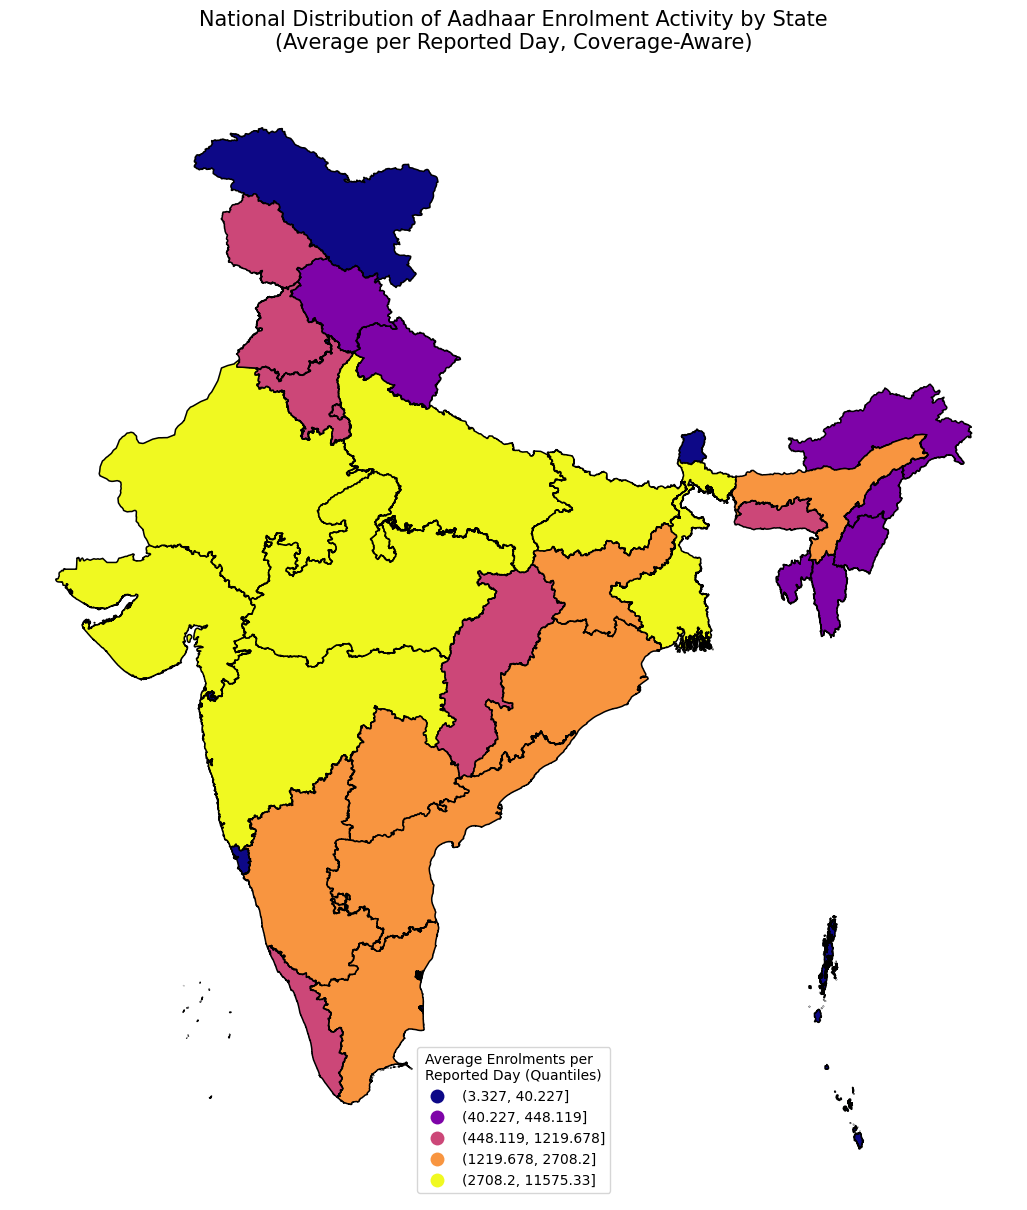

In [274]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(13, 15))

india_map_data.plot(
    column='enrolment_quantile',
    cmap='plasma',        # clear, colorblind-safe
    linewidth=1.1,
    ax=ax,
    edgecolor='black',
    legend=True,
    legend_kwds={
        'title': 'Average Enrolments per\nReported Day (Quantiles)',
        'loc': 'lower center'
    },
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "black",
        "label": "No reported data"
    }
)

ax.set_title(
    "National Distribution of Aadhaar Enrolment Activity by State\n"
    "(Average per Reported Day, Coverage-Aware)",
    fontsize=15,
    pad=20
)

ax.axis('off')
plt.show()


In [275]:
print(
    "Legend Note:\n"
    "States are grouped into quantiles based on average Aadhaar enrolments per reported day. \n"
    "Color differences reflect relative enrolment activity on days when states reported data. \n"
    "This visualization normalizes reporting gaps and does not represent population size, \n"
    "coverage completeness, or enrolment demand.\n"
)


Legend Note:
States are grouped into quantiles based on average Aadhaar enrolments per reported day. 
Color differences reflect relative enrolment activity on days when states reported data. 
This visualization normalizes reporting gaps and does not represent population size, 
coverage completeness, or enrolment demand.



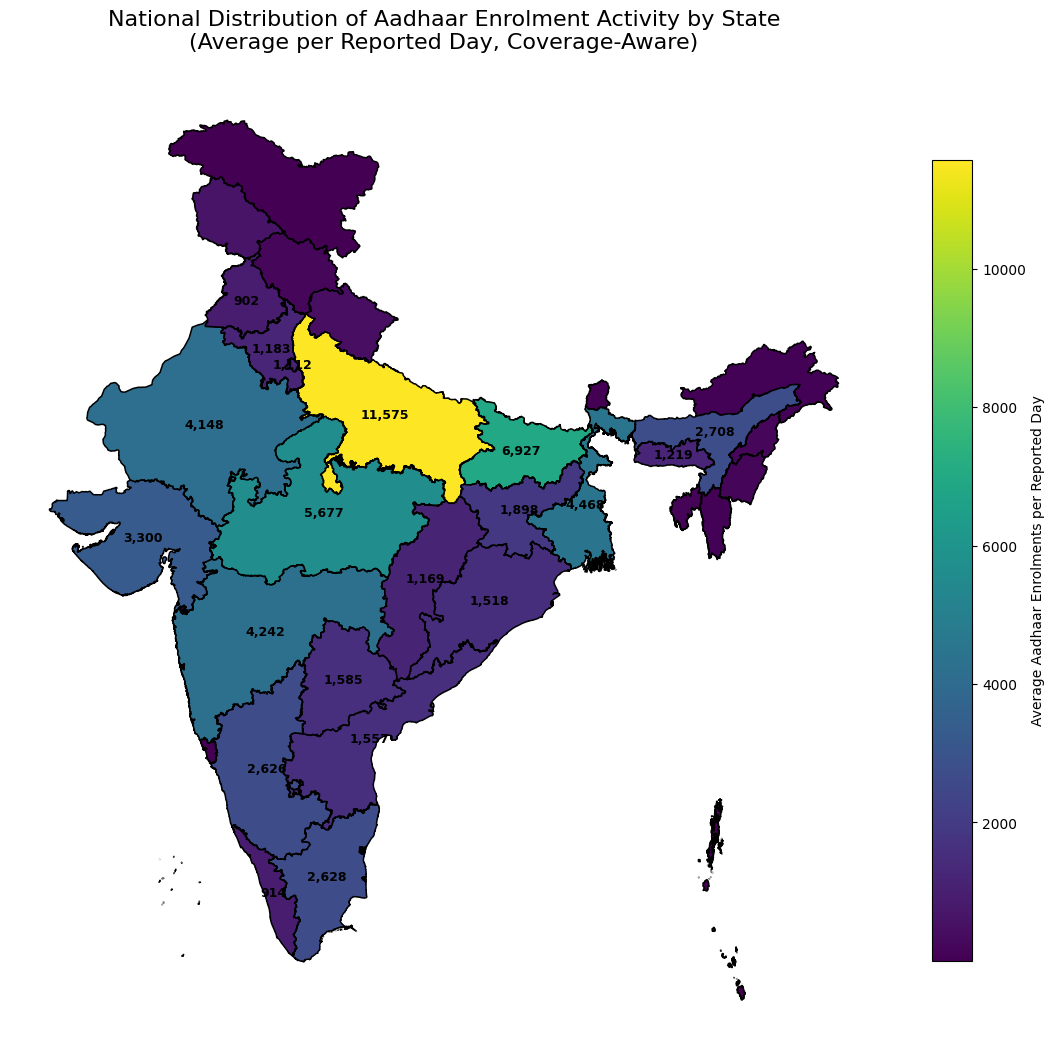

In [276]:
import matplotlib.pyplot as plt

# 1️⃣ Create figure
fig, ax = plt.subplots(1, 1, figsize=(14, 16))

# 2️⃣ Plot India map
india_map_data.plot(
    column='avg_enrolments_per_reported_day',
    cmap='viridis',
    linewidth=1.1,
    ax=ax,
    edgecolor='black',
    legend=True,
    legend_kwds={
        'label': "Average Aadhaar Enrolments per Reported Day",
        'shrink': 0.65
    },
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "black",
        "label": "No reported data"
    }
)

ax.set_title(
    "National Distribution of Aadhaar Enrolment Activity by State\n"
    "(Average per Reported Day, Coverage-Aware)",
    fontsize=16,
    pad=20
)

ax.axis('off')

# --------------------------------------------------
# 3️⃣ OPTIONAL: Add value labels for TOP states only
# --------------------------------------------------

top_states = (
    india_map_data[['shapeName', 'avg_enrolments_per_reported_day', 'geometry']]
    .dropna()
    .sort_values('avg_enrolments_per_reported_day', ascending=False)
    .head(20)   # label only top 20 states
)

for _, row in top_states.iterrows():
    centroid = row.geometry.centroid
    ax.text(
        centroid.x,
        centroid.y,
        f"{int(row.avg_enrolments_per_reported_day):,}",
        fontsize=9,
        ha='center',
        va='center',
        color='black',
        fontweight='bold'
    )

# 4️⃣ Show final map
plt.show()


In [277]:
print(
    "Legend Note:\n"
    "States are colored using a continuous scale based on the average number of \n"
    "Aadhaar enrolments per reported day. Darker colors indicate higher enrolment \n"
    "activity on days when the state reported data. This visualization does not \n"
    "represent population size, per-capita rates, or enrolment demand.\n"
)


Legend Note:
States are colored using a continuous scale based on the average number of 
Aadhaar enrolments per reported day. Darker colors indicate higher enrolment 
activity on days when the state reported data. This visualization does not 
represent population size, per-capita rates, or enrolment demand.



In [278]:
# Extract month name (ordered)
df['month'] = df['date'].dt.month
df['month_name'] = df['date'].dt.strftime('%B')

# Monthly observed totals and reporting days
monthly_stats = (
    df.groupby(['month', 'month_name'])
      .agg(
          total_enrolments=('total_daily_enrolement', 'sum'),
          reporting_days=('date', 'nunique')
      )
      .reset_index()
      .sort_values('month')
)

# Average enrolments per reported day (MONTH-LEVEL)
monthly_stats['avg_enrolments_per_reported_day'] = (
    monthly_stats['total_enrolments'] / monthly_stats['reporting_days']
)

monthly_stats

,month,month_name,total_enrolments,reporting_days,avg_enrolments_per_reported_day
0,3,March,16582,9,1842.444444
1,4,April,257438,1,257438.000000
2,5,May,183072,1,183072.000000
3,6,June,215734,1,215734.000000
4,7,July,616868,1,616868.000000
5,9,September,1474049,30,49134.966667
6,10,October,816862,18,45381.222222
7,11,November,1090449,20,54522.450000
8,12,December,758611,11,68964.636364


## State Level Analysis 

In [279]:
#national_reporting_days = df['date'].nunique()
national_reporting_days = df['date'].nunique()
national_reporting_days


92

In [280]:
state_name = "Uttar Pradesh"
df_up = df[df['state'] == state_name].copy()


In [281]:
# % of National Reporting Window (UP)
up_reporting_days = df_up['date'].nunique()
up_reporting_days


88

In [282]:
# Date Range of Reporting (UP)
up_date_range = (
    df_up['date'].min(),
    df_up['date'].max()
)

up_date_range


(Timestamp('2025-03-09 00:00:00'), Timestamp('2025-12-31 00:00:00'))

In [283]:
up_coverage_pct = (up_reporting_days / national_reporting_days) * 100
up_coverage_pct


95.65217391304348

In [284]:
# Number of Districts Reporting at Least Once (UP)
up_districts_reporting = df_up['district'].nunique()
up_districts_reporting


77

In [285]:

# Average registrations per district per reporting day (UP)
up_total_enrolments = df_up['total_daily_enrolement'].sum()

avg_enrolments_per_district_per_day = (
    up_total_enrolments /
    (up_reporting_days * up_districts_reporting)
)

avg_enrolments_per_district_per_day


np.float64(150.32895513577333)

In [286]:
section_a_df = pd.DataFrame({
    "Metric": [
        "Reporting days (Uttar Pradesh)",
        "National reporting days",
        "Coverage of national window (%)",
        "Districts reporting at least once",
        "Reporting date range",
        "Avg enrolments per district per reporting day"
    ],
    "Value": [
        up_reporting_days,
        national_reporting_days,
        round(up_coverage_pct, 1),
        up_districts_reporting,
        f"{up_date_range[0].date()} to {up_date_range[1].date()}",
        round(avg_enrolments_per_district_per_day, 2)
    ]
})

section_a_df


,Metric,Value
0,Reporting days (Uttar Pradesh),88
1,National reporting days,92
2,Coverage of national window (%),95.7
3,Districts reporting at least once,77
4,Reporting date range,2025-03-09 to 2025-12-31
5,Avg enrolments per district per reporting day,150.33


In [287]:
up_avg_enrolments_per_reported_day = (
    up_total_enrolments / up_reporting_days
)

up_avg_enrolments_per_reported_day


np.float64(11575.329545454546)

In [288]:
section_b_df = pd.DataFrame({
    "Metric": [
        "Total enrolments (reported days only)",
        "Average enrolments per reported day",
        "Reporting days",
        "Districts reporting"
    ],
    "Value": [
        int(up_total_enrolments),
        round(up_avg_enrolments_per_reported_day, 2),
        up_reporting_days,
        up_districts_reporting
    ]
})

section_b_df


,Metric,Value
0,Total enrolments (reported days only),1018629.00
1,Average enrolments per reported day,11575.33
2,Reporting days,88.00
3,Districts reporting,77.00


In [289]:
# Daily Metrics (UP)
import pandas as pd

up_daily = (
    df_up.groupby('date')
    .agg(
        total_enrolments=('total_daily_enrolement', 'sum'),
        reporting_districts=('district', 'nunique')
    )
    .reset_index()
)

up_daily.head()


,date,total_enrolments,reporting_districts
0,2025-03-09,1113,8
1,2025-03-15,1604,6
2,2025-03-20,1552,7
3,2025-03-23,204,2
4,2025-03-27,920,9


In [290]:
import plotly.graph_objects as go

fig_up_daily = go.Figure()

# Line 1: Total enrolments
fig_up_daily.add_trace(
    go.Scatter(
        x=up_daily['date'],
        y=up_daily['total_enrolments'],
        mode='lines+markers',
        name='Total Enrolments (UP)',
        yaxis='y1'
    )
)

# Line 2: Reporting districts
fig_up_daily.add_trace(
    go.Scatter(
        x=up_daily['date'],
        y=up_daily['reporting_districts'],
        mode='lines+markers',
        name='Reporting Districts (UP)',
        yaxis='y2'
    )
)

fig_up_daily.update_layout(
    title=(
        "Uttar Pradesh: Daily Aadhaar Enrolments and Reporting Coverage<br>"
        "<sup>(Reported Days Only)</sup>"
    ),
    xaxis_title="Date",
    yaxis=dict(
        title="Total Enrolments",
        side="left"
    ),
    yaxis2=dict(
        title="Number of Reporting Districts",
        overlaying="y",
        side="right"
    ),
    legend=dict(x=0.01, y=0.99),
    transition_duration=600
)

fig_up_daily.show()


In [291]:
weekday_order = [
    'Monday', 'Tuesday', 'Wednesday',
    'Thursday', 'Friday', 'Saturday', 'Sunday'
]

up_daywise = (
    df_up.groupby('day_name')['total_daily_enrolement']
    .sum()
    .reindex(weekday_order)
    .reset_index()
)


In [292]:
import plotly.express as px

fig_up_weekday = px.bar(
    up_daywise,
    x='day_name',
    y='total_daily_enrolement',
    title=(
        "Uttar Pradesh: Total Aadhaar Enrolments by Day of Week<br>"
        "<sup>(Reported Records Only)</sup>"
    ),
    labels={
        'day_name': 'Day of Week',
        'total_daily_enrolement': 'Total Enrolments'
    }
)

fig_up_weekday.update_layout(
    xaxis=dict(categoryorder='array', categoryarray=weekday_order),
    transition_duration=600
)

fig_up_weekday.show()


In [293]:
up_dom = (
    df_up.groupby('day')['total_daily_enrolement']
    .sum()
    .reset_index()
    .sort_values('day')
)


In [294]:
fig_up_dom = px.bar(
    up_dom,
    x='day',
    y='total_daily_enrolement',
    title=(
        "Uttar Pradesh: Total Aadhaar Enrolments by Day of Month<br>"
        "<sup>(Reported Records Only)</sup>"
    ),
    labels={
        'day': 'Day of Month',
        'total_daily_enrolement': 'Total Enrolments'
    }
)

fig_up_dom.update_layout(
    xaxis=dict(tickmode='linear', tick0=1, dtick=1),
    transition_duration=600
)

fig_up_dom.show()


### district in state analysis 

In [295]:
#DISTRICT-LEVEL HETEROGENEITY (UTTAR PRADESH)
up_total_districts = df_up['district'].nunique()
up_total_districts


77

In [296]:
district_stats_up = (
    df_up.groupby('district')
    .agg(
        total_enrolments=('total_daily_enrolement', 'sum'),
        reporting_days=('date', 'nunique')
    )
    .reset_index()
)

# Average enrolments per reported day (district)
district_stats_up['avg_enrolments_per_reported_day'] = (
    district_stats_up['total_enrolments'] /
    district_stats_up['reporting_days']
)

district_stats_up.head()


,district,total_enrolments,reporting_days,avg_enrolments_per_reported_day
0,agra,29910,85,351.882353
1,aligarh,26192,84,311.809524
2,ambedkar nagar,8002,78,102.589744
3,amethi,7197,77,93.467532
4,amroha,8142,78,104.384615


In [297]:
import plotly.express as px

fig_dist_coverage = px.histogram(
    district_stats_up,
    x='reporting_days',
    nbins=20,
    title=(
        "Uttar Pradesh: Distribution of Reporting Days Across Districts<br>"
        "<sup>Each bar represents number of districts</sup>"
    ),
    labels={
        'reporting_days': 'Number of Reporting Days (District)',
        'count': 'Number of Districts'
    }
)

fig_dist_coverage.update_layout(
    transition_duration=600
)

fig_dist_coverage.show()


In [298]:
import plotly.express as px

fig_box = px.box(
    district_stats_up,
    y='reporting_days',
    points='all',
    title=(
        "Uttar Pradesh: Distribution of Reporting Days Across Districts<br>"
        "<sup>Box plot highlighting coverage consistency and outliers</sup>"
    ),
    labels={
        'reporting_days': 'Number of Reporting Days'
    }
)

fig_box.show()


In [299]:
fig_scatter = px.scatter(
    district_stats_up,
    x='reporting_days',
    y='avg_enrolments_per_reported_day',
    title=(
        "Uttar Pradesh: Reporting Coverage vs Average Daily Enrolment<br>"
        "<sup>Assessing bias due to uneven reporting</sup>"
    ),
    labels={
        'reporting_days': 'Number of Reporting Days',
        'avg_enrolments_per_reported_day': 'Avg Daily Enrolment'
    },
    trendline='lowess'
)

fig_scatter.show()


In [300]:
district_stats_up['coverage_band'] = pd.cut(
    district_stats_up['reporting_days'],
    bins=[0, 30, 60, 90, 366],
    labels=['Low', 'Medium', 'High', 'Very High']
)

fig_band = px.bar(
    district_stats_up['coverage_band'].value_counts().reset_index(),
    x='coverage_band',
    y='count',
    title=(
        "Uttar Pradesh: Districts by Reporting Coverage Category<br>"
        "<sup>Coverage bands based on number of reporting days</sup>"
    ),
    labels={
        'coverage_band': 'Coverage Category',
        'count': 'Number of Districts'
    }
)

fig_band.show()


In [301]:
# Top 5 Districts by Avg Enrolments per Reported Day (Coverage-Aware)
up_reporting_days = df_up['date'].nunique()
coverage_threshold = 0.30 * up_reporting_days
coverage_threshold
districts_filtered = district_stats_up[
    district_stats_up['reporting_days'] >= coverage_threshold
].copy()

len(districts_filtered)


76

In [302]:
top5_districts_up = (
    districts_filtered
    .sort_values('avg_enrolments_per_reported_day', ascending=False)
    .head(5)
)
fig_top5 = px.bar(
    top5_districts_up.sort_values('avg_enrolments_per_reported_day'),
    x='avg_enrolments_per_reported_day',
    y='district',
    orientation='h',
    title=(
        "Top 5 Districts in Uttar Pradesh by Average Aadhaar Enrolments per Reported Day<br>"
        "<sup>Districts with ≥30% of UP reporting days only</sup>"
    ),
    labels={
        'avg_enrolments_per_reported_day': 'Avg Enrolments per Reported Day',
        'district': 'District'
    },
    hover_data={
        'reporting_days': True,
        'total_enrolments': True
    }
)

fig_top5.update_layout(
    transition_duration=600
)

fig_top5.show()



In [303]:
top5_table = top5_districts_up[
    ['district', 'reporting_days', 'avg_enrolments_per_reported_day', 'total_enrolments']
].copy()

top5_table['avg_enrolments_per_reported_day'] = (
    top5_table['avg_enrolments_per_reported_day'].round(0).astype(int)
)

top5_table


,district,reporting_days,avg_enrolments_per_reported_day,total_enrolments
9,bahraich,84,468,39338
72,sitapur,82,376,30854
0,agra,85,352,29910
14,bareilly,82,339,27811
35,hardoi,80,315,25193


In [304]:

import pandas as pd

# Filter for Uttar Pradesh (assumes df already loaded and date parsed)
df_up = df[df['state'] == 'Uttar Pradesh'].copy()

# Total enrolments (reported days only)
up_total_enrolments = df_up['total_daily_enrolement'].sum()

# Age-group totals
age_group_up = pd.DataFrame({
    "Age Group": ["0–5 years", "5–17 years", "18+ years"],
    "Enrolments": [
        df_up['age_0_5'].sum(),
        df_up['age_5_17'].sum(),
        df_up['age_18_greater'].sum()
    ]
})

# Percentage share
age_group_up["Share (%)"] = (
    age_group_up["Enrolments"] / up_total_enrolments * 100
).round(2)

age_group_up


,Age Group,Enrolments,Share (%)
0,0–5 years,521045,51.15
1,5–17 years,479682,47.09
2,18+ years,17902,1.76


In [305]:
import plotly.express as px

fig_age_up = px.pie(
    age_group_up,
    values="Share (%)",
    names="Age Group",
    title=(
        "Age-Group Composition of Aadhaar Enrolment Activity — Uttar Pradesh<br>"
        "<sup>(Reported Days Only)</sup>"
    ),
    hole=0.4
)

fig_age_up.update_traces(
    textposition="inside",
    textinfo="percent+label",
    pull=[0.02, 0.02, 0.02]  # subtle emphasis, not misleading
)

fig_age_up.update_layout(
    legend_title="Age Group",
    transition_duration=600
)

fig_age_up.show()


In [306]:
print(
    "Interpretation Note:\n"
    "This chart represents the composition of Aadhaar enrolment transactions in \n"
    "Uttar Pradesh by age group, aggregated over available reporting days only. \n"
    "Percentages reflect enrolment activity and should not be interpreted as the \n"
    "age distribution of the population.\n" \
    ""
)


Interpretation Note:
This chart represents the composition of Aadhaar enrolment transactions in 
Uttar Pradesh by age group, aggregated over available reporting days only. 
Percentages reflect enrolment activity and should not be interpreted as the 
age distribution of the population.



### Geo Map

In [307]:
# Load All-India Pincode Boundary GeoJSON
pincode_gdf = gpd.read_file("All_India_pincode_Boundary-19312.geojson")
pincode_gdf.head()


,Pincode,Office_Name,Division,Region,Circle,geometry
0,110001,New Delhi GPO,New Delhi GPO,,Delhi,"POLYGON ((77.18584 28.62087, 77.18645 28.62041..."
1,110002,Indraprastha HO,New Delhi Central,,Delhi,"POLYGON ((77.2494 28.60809, 77.25127 28.60278,..."
2,110003,Lodi Road HO,New Delhi South,,Delhi,"POLYGON ((77.22925 28.61031, 77.22845 28.60909..."
3,110004,Rashtrapati Bhawan SO,New Delhi Central,,Delhi,"POLYGON ((77.18584 28.62087, 77.18394 28.61828..."
4,110005,Karol Bagh SO,New Delhi Central,,Delhi,"POLYGON ((77.18258 28.66114, 77.18278 28.66011..."


In [332]:
df_up = df[df['state'] == 'Uttar Pradesh'].copy()
df_up.shape

(110369, 12)

In [309]:
pincode_stats_up = (
    df_up.groupby('pincode')
    .agg(
        total_enrolments=('total_daily_enrolement', 'sum'),
        reporting_days=('date', 'nunique')
    )
    .reset_index()
)

pincode_stats_up['avg_enrolments_per_reported_day'] = (
    pincode_stats_up['total_enrolments'] /
    pincode_stats_up['reporting_days']
)

pincode_stats_up.head()


,pincode,total_enrolments,reporting_days,avg_enrolments_per_reported_day
0,121705,197,61,3.229508
1,201001,4549,76,59.855263
2,201002,1145,73,15.684932
3,201003,375,70,5.357143
4,201004,4,4,1.000000


In [310]:
# Rename for consistency
pincode_gdf = pincode_gdf.rename(columns={'Pincode': 'pincode'})
pincode_stats_up['pincode'] = pincode_stats_up['pincode'].astype(str)
pincode_gdf['pincode'] = pincode_gdf['pincode'].astype(str)



In [311]:
pincode_gdf.columns


Index(['pincode', 'Office_Name', 'Division', 'Region', 'Circle', 'geometry'], dtype='object')

In [333]:
pincode_up_gdf = pincode_gdf[
    pincode_gdf['Circle']
    .str.lower()
    .str.contains('uttar pradesh ', na=False)
].copy()
pincode_up_gdf.shape


(1655, 6)

In [334]:
# Merge Aadhaar stats
pincode_map_up = pincode_up_gdf.merge(
    pincode_stats_up,
    on='pincode',
    how='left'
)
pincode_map_up.shape

(1655, 9)

In [335]:
sorted(pincode_gdf['Circle'].dropna().unique())


['Andhra Pradesh ',
 'Assam ',
 'Bihar ',
 'Chattisgarh ',
 'Delhi ',
 'Gujarat ',
 'Haryana ',
 'Himachal Pradesh ',
 'Jammukashmir ',
 'Jharkhand ',
 'Karnataka ',
 'Kerala ',
 'Madhya Pradesh ',
 'Maharashtra ',
 'North Eastern ',
 'Odisha ',
 'Punjab ',
 'Rajasthan ',
 'Tamilnadu ',
 'Telangana ',
 'Uttar Pradesh ',
 'Uttarakhand ',
 'West Bengal ']

In [336]:

pincode_gdf['Circle'].value_counts().head(20)


Circle
Tamilnadu            2063
Maharashtra          1678
Uttar Pradesh        1655
Kerala               1428
Karnataka            1354
Andhra Pradesh       1236
West Bengal          1169
Rajasthan            1007
Gujarat              1003
Odisha                937
Bihar                 876
Madhya Pradesh        772
Telangana             679
Assam                 576
Punjab                529
Himachal Pradesh      438
Jharkhand             379
North Eastern         334
Haryana               316
Uttarakhand           301
Name: count, dtype: int64

In [337]:

pincode_map_up.shape

(1655, 9)

In [338]:

pincode_map_up.head(2)


,pincode,Office_Name,Division,Region,Circle,geometry,total_enrolments,reporting_days,avg_enrolments_per_reported_day
0,201001,Ghaziabad HO,Ghaziabad,Lucknow HQ,Uttar Pradesh,"POLYGON ((77.43345 28.68832, 77.42856 28.68402...",4549.0,76.0,59.855263
1,201002,Kavi Nagar SO,Ghaziabad,Lucknow HQ,Uttar Pradesh,"POLYGON ((77.44854 28.6474, 77.45079 28.64913,...",1145.0,73.0,15.684932


In [339]:
import numpy as np

pincode_map_up['log_avg_enrolments'] = np.log1p(
    pincode_map_up['avg_enrolments_per_reported_day']
)


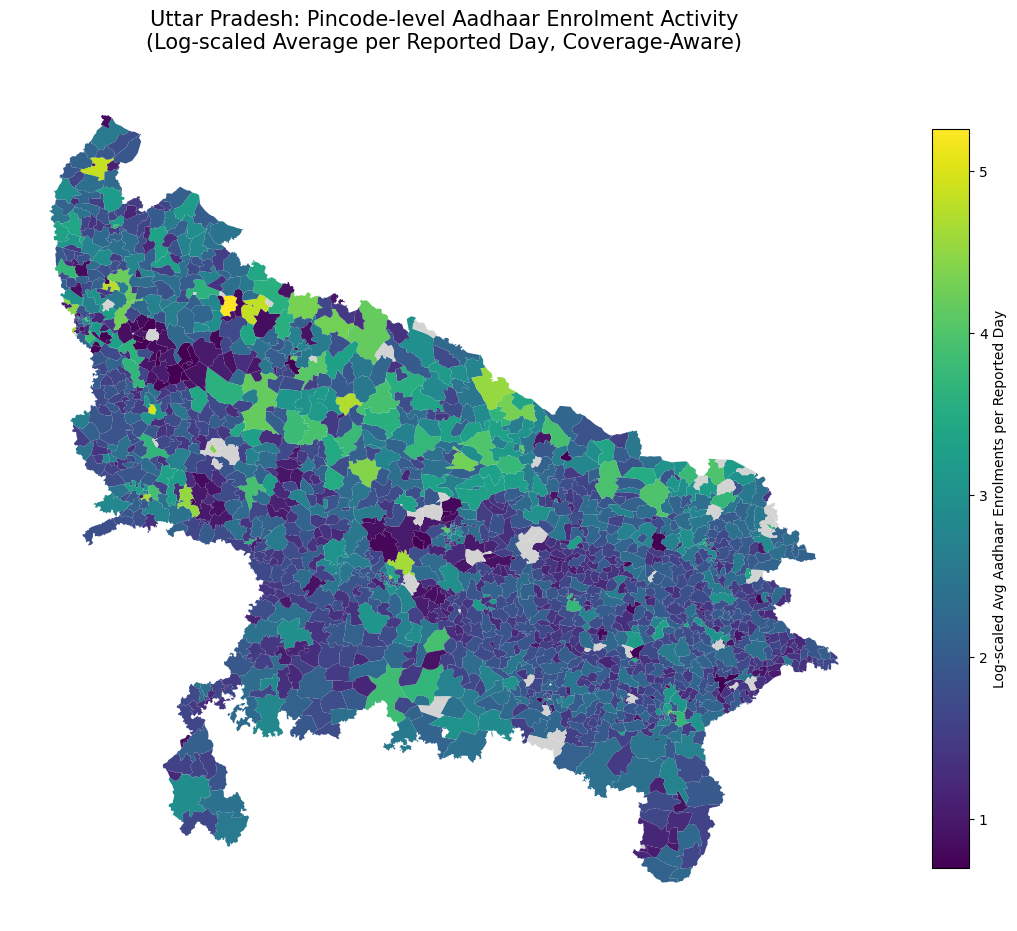

In [340]:
fig, ax = plt.subplots(1, 1, figsize=(14, 16))

pincode_map_up.plot(
    column='log_avg_enrolments',
    cmap='viridis',
    linewidth=0.05,
    ax=ax,
    edgecolor='none',
    legend=True,
    legend_kwds={
        'label': "Log-scaled Avg Aadhaar Enrolments per Reported Day",
        'shrink': 0.6
    },
    missing_kwds={
        "color": "lightgrey",
        "label": "No reported data"
    }
)

ax.set_title(
    "Uttar Pradesh: Pincode-level Aadhaar Enrolment Activity\n"
    "(Log-scaled Average per Reported Day, Coverage-Aware)",
    fontsize=15,
    pad=20
)

ax.axis('off')
plt.show()


In [343]:
df1 = pd.read_csv('aadhar_cleaned_v_final.csv')

In [344]:
total_districts = df1['district'].nunique()
total_districts

772

In [345]:
num_states = df1['state'].nunique()
num_districts = df1['district'].nunique()
num_pincodes = df1['pincode'].nunique()

print(f"Unique States   : {num_states}")
print(f"Unique Districts: {num_districts}")
print(f"Unique Pincodes : {num_pincodes}")

Unique States   : 36
Unique Districts: 772
Unique Pincodes : 19457


In [346]:
import pandas as pd

# Create summary DataFrame
raw_summary = pd.DataFrame({
    "Metric": [
        "Unique States and Union Territories",
        "Unique Districts",
        "Unique Pincodes",
    ],
    "Value": [
        num_states,
        num_districts,
        num_pincodes,
    ]
})

# Display heading
display(pd.DataFrame({"": ["Before Cleaning"]}).style
        .set_properties(**{
            "font-size": "18px",
            "font-weight": "bold",
            "text-align": "center"
        })
        .hide(axis="index")
        .hide(axis="columns")
)

# Style the table in orange
raw_summary.style \
    .set_caption("After Cleaning") \
    .set_table_styles([
        {
            "selector": "caption",
            "props": [
                ("caption-side", "top"),
                ("font-size", "16px"),
                ("font-weight", "bold"),
                ("color", "#FF6F2A")  # orange
            ]
        },
        {
            "selector": "th",
            "props": [
                ("background-color", "#FF6E26"),
                ("color", "white"),
                ("font-weight", "bold"),
                ("text-align", "left")
            ]
        },
        {
            "selector": "td",
            "props": [
                ("background-color", "#FFE4D7"),
                ("color", "#FF6F2A"),
                ("font-weight", "semibold"),
                ("text-align", "left")
            ]
        }
    ]) \
    .format({"Value": "{:,}"})



Before Cleaning


,Metric,Value
0,Unique States and Union Territories,36
1,Unique Districts,772
2,Unique Pincodes,"19,457"
